In [35]:
# importing desi premade stuff in nersc

%pylab inline
import desispec
import desitarget
import desimodel.io
print('desimodel ', desimodel.__version__)
print('desispec  ', desispec.__version__)
print('desitarget', desitarget.__version__)

#fiberpos = desimodel.io.load_fiberpos()
#figure(figsize=(8,8))
#plot(fiberpos['X'], fiberpos['Y'], 'k.', alpha=0.5, markeredgecolor='none')


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
desimodel  0.18.0
desispec   0.56.5
desitarget 2.6.0


/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['norm', 'convolve', 'hstack', 'vstack', 'yticks', 'xticks', 'hist']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel


import datetime
date = datetime.datetime.now()
day = date.strftime("%d")
month = date.strftime("%b")

# imports for the sky map
from astropy.io import ascii
import astropy.units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=69.3 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.287)

#import plotly.graph_objects as go
import seaborn as sns
from matplotlib.gridspec import GridSpec

import scipy


In [3]:
import astropy.coordinates as coord
from astropy.coordinates import ICRS, Galactic
from astropy.table import Table, hstack, vstack
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u

In [4]:
# iron coadded fits table
path = '/global/cfs/cdirs/desi/science/mws/redux/iron/rv_output/230211/'
filename = path+'rvtab-hpxcoadd-all.fits'

In [5]:
# checking tables in fits file
hdul=fits.open(filename)
hdul.info()
hdul.close()

Filename: /global/cfs/cdirs/desi/science/mws/redux/iron/rv_output/230211/rvtab-hpxcoadd-all.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  RVTAB         1 BinTableHDU    128   6165491R x 37C   [D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, K, K, 2A, D, D, K, E, E, E, L, D, 6A, 45A, 7A, 6A]   
  2  FIBERMAP      1 BinTableHDU    203   6165491R x 81C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E, 45A, K, K, K, K, K, K, K, K, K, K, K, K, K]   
  3  SCORES        1 BinTableHDU     95   6165491R x 43C   [K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 45A]   
  4  GAIA          1 BinTableHDU    346   6165491R x 153C   [K, 28A, K, K, D, D, E, D, E, D, E, E, E, D

In [6]:
rvtab = Table.read(filename, hdu = "RVTAB")
fmap = Table.read(filename, hdu = "FIBERMAP")
gaiatab = Table.read(filename, hdu = "GAIA")

In [7]:
print(f"Tiles table columns: {rvtab.colnames}")
gaiatab[0:10]


Tiles table columns: ['VRAD', 'VRAD_ERR', 'VRAD_SKEW', 'VRAD_KURT', 'LOGG', 'TEFF', 'ALPHAFE', 'FEH', 'LOGG_ERR', 'TEFF_ERR', 'ALPHAFE_ERR', 'FEH_ERR', 'VSINI', 'NEXP', 'CHISQ_TOT', 'CHISQ_C_TOT', 'CHISQ_B', 'CHISQ_C_B', 'CHISQ_R', 'CHISQ_C_R', 'CHISQ_Z', 'CHISQ_C_Z', 'RVS_WARN', 'REF_ID', 'REF_CAT', 'TARGET_RA', 'TARGET_DEC', 'TARGETID', 'SN_B', 'SN_R', 'SN_Z', 'SUCCESS', 'RR_Z', 'RR_SPECTYPE', 'cat_filename', 'SURVEY', 'PROGRAM']


SOLUTION_ID,DESIGNATION,SOURCE_ID,RANDOM_INDEX,REF_EPOCH,RA,RA_ERROR,DEC,DEC_ERROR,PARALLAX,PARALLAX_ERROR,PARALLAX_OVER_ERROR,PM,PMRA,PMRA_ERROR,PMDEC,PMDEC_ERROR,RA_DEC_CORR,RA_PARALLAX_CORR,RA_PMRA_CORR,RA_PMDEC_CORR,DEC_PARALLAX_CORR,DEC_PMRA_CORR,DEC_PMDEC_CORR,PARALLAX_PMRA_CORR,PARALLAX_PMDEC_CORR,PMRA_PMDEC_CORR,ASTROMETRIC_N_OBS_AL,ASTROMETRIC_N_OBS_AC,ASTROMETRIC_N_GOOD_OBS_AL,ASTROMETRIC_N_BAD_OBS_AL,ASTROMETRIC_GOF_AL,ASTROMETRIC_CHI2_AL,ASTROMETRIC_EXCESS_NOISE,ASTROMETRIC_EXCESS_NOISE_SIG,ASTROMETRIC_PARAMS_SOLVED,ASTROMETRIC_PRIMARY_FLAG,NU_EFF_USED_IN_ASTROMETRY,PSEUDOCOLOUR,PSEUDOCOLOUR_ERROR,RA_PSEUDOCOLOUR_CORR,DEC_PSEUDOCOLOUR_CORR,PARALLAX_PSEUDOCOLOUR_CORR,PMRA_PSEUDOCOLOUR_CORR,PMDEC_PSEUDOCOLOUR_CORR,ASTROMETRIC_MATCHED_TRANSITS,VISIBILITY_PERIODS_USED,ASTROMETRIC_SIGMA5D_MAX,MATCHED_TRANSITS,NEW_MATCHED_TRANSITS,MATCHED_TRANSITS_REMOVED,IPD_GOF_HARMONIC_AMPLITUDE,IPD_GOF_HARMONIC_PHASE,IPD_FRAC_MULTI_PEAK,IPD_FRAC_ODD_WIN,RUWE,SCAN_DIRECTION_STRENGTH_K1,SCAN_DIRECTION_STRENGTH_K2,SCAN_DIRECTION_STRENGTH_K3,SCAN_DIRECTION_STRENGTH_K4,SCAN_DIRECTION_MEAN_K1,SCAN_DIRECTION_MEAN_K2,SCAN_DIRECTION_MEAN_K3,SCAN_DIRECTION_MEAN_K4,DUPLICATED_SOURCE,PHOT_G_N_OBS,PHOT_G_MEAN_FLUX,PHOT_G_MEAN_FLUX_ERROR,PHOT_G_MEAN_FLUX_OVER_ERROR,PHOT_G_MEAN_MAG,PHOT_BP_N_OBS,PHOT_BP_MEAN_FLUX,PHOT_BP_MEAN_FLUX_ERROR,PHOT_BP_MEAN_FLUX_OVER_ERROR,PHOT_BP_MEAN_MAG,PHOT_RP_N_OBS,PHOT_RP_MEAN_FLUX,PHOT_RP_MEAN_FLUX_ERROR,PHOT_RP_MEAN_FLUX_OVER_ERROR,PHOT_RP_MEAN_MAG,PHOT_BP_RP_EXCESS_FACTOR,PHOT_BP_N_CONTAMINATED_TRANSITS,PHOT_BP_N_BLENDED_TRANSITS,PHOT_RP_N_CONTAMINATED_TRANSITS,PHOT_RP_N_BLENDED_TRANSITS,PHOT_PROC_MODE,BP_RP,BP_G,G_RP,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,RV_METHOD_USED,RV_NB_TRANSITS,RV_NB_DEBLENDED_TRANSITS,RV_VISIBILITY_PERIODS_USED,RV_EXPECTED_SIG_TO_NOISE,RV_RENORMALISED_GOF,RV_CHISQ_PVALUE,RV_TIME_DURATION,RV_AMPLITUDE_ROBUST,RV_TEMPLATE_TEFF,RV_TEMPLATE_LOGG,RV_TEMPLATE_FE_H,RV_ATM_PARAM_ORIGIN,VBROAD,VBROAD_ERROR,VBROAD_NB_TRANSITS,GRVS_MAG,GRVS_MAG_ERROR,GRVS_MAG_NB_TRANSITS,RVS_SPEC_SIG_TO_NOISE,PHOT_VARIABLE_FLAG,L,B,ECL_LON,ECL_LAT,IN_QSO_CANDIDATES,IN_GALAXY_CANDIDATES,NON_SINGLE_STAR,HAS_XP_CONTINUOUS,HAS_XP_SAMPLED,HAS_RVS,HAS_EPOCH_PHOTOMETRY,HAS_EPOCH_RV,HAS_MCMC_GSPPHOT,HAS_MCMC_MSC,IN_ANDROMEDA_SURVEY,CLASSPROB_DSC_COMBMOD_QUASAR,CLASSPROB_DSC_COMBMOD_GALAXY,CLASSPROB_DSC_COMBMOD_STAR,TEFF_GSPPHOT,TEFF_GSPPHOT_LOWER,TEFF_GSPPHOT_UPPER,LOGG_GSPPHOT,LOGG_GSPPHOT_LOWER,LOGG_GSPPHOT_UPPER,MH_GSPPHOT,MH_GSPPHOT_LOWER,MH_GSPPHOT_UPPER,DISTANCE_GSPPHOT,DISTANCE_GSPPHOT_LOWER,DISTANCE_GSPPHOT_UPPER,AZERO_GSPPHOT,AZERO_GSPPHOT_LOWER,AZERO_GSPPHOT_UPPER,AG_GSPPHOT,AG_GSPPHOT_LOWER,AG_GSPPHOT_UPPER,EBPMINRP_GSPPHOT,EBPMINRP_GSPPHOT_LOWER,EBPMINRP_GSPPHOT_UPPER,LIBNAME_GSPPHOT,EBV
int64,bytes28,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,bytes20,float64,float64,float64,float64,bool,bool,int16,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes20,float32
--,None,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False,--,--,--

In [8]:
#rv table
#g-r color is log scale so --> -2.5 * np.log10(['FLUX_G'] / ['FLUX_R'])
gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
 
#fibermap magnitudes
gmag=-2.5*np.log10(fmap['FLUX_G'])+22.5
rmag = -2.5*np.log10(fmap['FLUX_R'])+22.5


/tmp/ipykernel_1919782/77781774.py:3: RuntimeWarning: divide by zero encountered in true_divide
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919782/77781774.py:3: RuntimeWarning: invalid value encountered in true_divide
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919782/77781774.py:3: RuntimeWarning: divide by zero encountered in log10
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919782/77781774.py:3: RuntimeWarning: invalid value encountered in log10
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919782/77781774.py:6: RuntimeWarning: divide by zero encountered in log10
  gmag=-2.5*np.log10(fmap['FLUX_G'])+22.5
/tmp/ipykernel_1919782/77781774.py:6: RuntimeWarning: invalid value encountered in log10
  gmag=-2.5*np.log10(fmap['FLUX_G'])+22.5
/tmp/ipykernel_1919782/77781774.py:7: RuntimeWarning: divide by zero encountered in log10
  rmag = -2.5*np.log10(fmap['FLUX_R'])+22.5
/tmp/

In [9]:
# testing the to make sure the indices are the same for "SURVEY"
# and applying all other cuts
# vsini < 50 for ... (maybe within logical limit for MW)
# loggg > 4 for dwarf stars
iprim,=np.where(((rvtab["SURVEY"]=='main'))&
                (rvtab['RVS_WARN'] == 0) & 
                (rvtab['RR_SPECTYPE'] == 'STAR')&
                (rvtab['VSINI']<50)&
                (rmag<19.0)&
                (np.isnan(gmr)==0)&
               (rvtab['LOGG']>4))



In [10]:
#turning fits table to a pandas dataframe (easier to manipulate imo)
df_rvtab = rvtab.to_pandas()
df_gaia = gaiatab.to_pandas()
df_fmap = fmap.to_pandas()
print(len(df_rvtab), len(df_gaia))

6165491 6165491


In [11]:
# column data in numpy array form with the cuts
ra = np.array(df_rvtab['TARGET_RA'][iprim])
dec = np.array(df_rvtab['TARGET_DEC'][iprim])
feh = np.array(df_rvtab['FEH'][iprim])
teff = np.array(df_rvtab['TEFF'][iprim])
vrad = np.array(df_rvtab['VRAD'][iprim]) # km/s
snr= np.array(df_rvtab['SN_R'][iprim])

survey = np.array(df_rvtab['SURVEY'][iprim])
program = np.array(df_rvtab['PROGRAM'][iprim])
#ref_cat = np.array(df_rvtab['REF_CAT'][iprim])
#ref_id = np.array(df_rvtab['REF_ID'][iprim])
alphafe = np.array(df_rvtab['ALPHAFE'][iprim])
feh = np.array(df_rvtab['FEH'][iprim])
alphafe_err = np.array(df_rvtab['ALPHAFE_ERR'][iprim])
feh_err = np.array(df_rvtab['FEH_ERR'][iprim])

pmra = np.array(df_gaia['PMRA'][iprim]) # milli arcsec /yr
pmdec = np.array(df_gaia['PMDEC'][iprim])
parallax = np.array(df_gaia["PARALLAX"][iprim])
parallax_error = np.array(df_gaia["PARALLAX_ERROR"][iprim])
color_gmr = np.array(df_fmap['FLUX_G'][iprim] - df_fmap['FLUX_R'][iprim])
mag_g = np.array(-2.5*np.log10(df_fmap['FLUX_G'][iprim])+22.5)
mag_r = np.array(rmag[iprim])
mag_r_index = np.where((mag_r>17)&(mag_r<17.25))

print('   with cuts:',len(ra), len(mag_g))
print('without cuts:', len(df_rvtab['TARGET_RA']))

   with cuts: 2051874 2051874
without cuts: 6165491


/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
# retrieving the indices of the different programs
dark_index = np.where(program==b'dark')
bright_index = np.where(program==b'bright')
backup_index = np.where(program==b'backup')
other_index = np.where(program==b'other')

# TEST phase spiral with GAIA distances

In [13]:
def phase_spiral_values(dist, ra, dec, pmra, pmdec, vrad, dist_min=0, dist_max=10):
    '''
    converts ra and dec coords to r,phi,z galactic coords
    inputs: 
            dist: distance object is from us in kpc
            ra: ra
            dec: dec
            pmra: ra proper motion 
            pmdec: dec proper motion
            vrad: line of sight velocity
            
            dist_min: min distance range
            dist_max: max distance range to be calulcat
    
    outputs: r,phi,z, and their respective velocities
    '''
    
    dist_index = np.where((dist<=dist_max) & (dist>dist_min))
    dist_cut = dist[dist_index]
    ra_cut = ra[dist_index]
    dec_cut = dec[dist_index]
    pmra_cut = pmra[dist_index]
    pmdec_cut = pmdec[dist_index]
    vrad_cut = vrad[dist_index]
    
    
    c= coord.ICRS(ra=ra_cut*u.deg,
              dec=dec_cut*u.deg,
                  distance=dist_cut*u.kpc,
                  pm_ra_cosdec=pmra_cut*u.mas/u.yr,
                  pm_dec=pmdec_cut*u.mas/u.yr,
                  radial_velocity=vrad_cut*u.km/u.s)
    
    # Define GC frame
    v_sun = coord.CartesianDifferential([11.1,245.,7.25]*u.km/u.s)
    gc_frame= coord.Galactocentric(galcen_distance=8.1*u.kpc,
                                       z_sun=25.*u.pc,
                                       galcen_v_sun=v_sun)
    cg= c.transform_to(gc_frame)

    cg.representation_type = 'cylindrical'
    
    r = cg.rho.to(u.kpc).value
    phi = cg.phi.degree
    z= cg.z.to(u.kpc).value
    v_r = cg.d_rho.to(u.km/u.s).value
    v_phi = (cg.d_phi*cg.rho).to(u.km/u.s,
            equivalencies=u.dimensionless_angles()).value
    v_z = cg.d_z.to(u.km/u.s).value
    
    
    return r, phi, z, v_r, v_phi, v_z


In [14]:

dist = 1/parallax
parallax_err_index = np.where((dist>0) &(parallax_error/parallax <.2))
print(len(dist), len(dist[parallax_err_index]))
#plt.hist(dist[parallax_err_index])


# sort into bright and dark program
dist_bright = dist[bright_index]

# brights for parallax
parallax_bright = parallax[bright_index]
parallax_error_bright = parallax_error[bright_index]

ra_bright = ra[bright_index]
dec_bright = dec[bright_index]

mag_r_bright = mag_r[bright_index]

feh_bright = feh[bright_index]

############################################################################################
############################################################################################
############################################################################################

# need distance, proper motion, and vrad

# sort into bright and dark program
dist_bright = dist[bright_index] # kpc

pmra_bright = pmra[bright_index] # mas/yr
pmdec_bright = pmdec[bright_index]

vrad_bright = vrad[bright_index] # km/s # line of sight velocity

ra_bright = ra[bright_index]
dec_bright = dec[bright_index]

snr_bright = snr[bright_index]
feh_bright=feh[bright_index]

print(len(feh_bright), len(ra_bright), len(parallax_bright), len(pmra_bright))



2051874 764238
1904231 1904231 1904231 1904231


# connie's set up (aka just looking at brights)

In [15]:
idxp,=np.where((rvtab["SURVEY"]=='main')&
                (rvtab["PROGRAM"]=='bright')&
                (rmag < 25.0) & # originally 19
                (rvtab['RVS_WARN'] == 0) &
                (rvtab['RR_SPECTYPE'] == 'STAR')&
                (rvtab['VSINI']<50)&
                (np.isnan(gmr)==0)&
                #(rvtab['LOGG']>4)& #for photo
                #(rvtab['SN_R']>10)&
                #(gaiatab['PARALLAX_ERROR']/gaiatab['PARALLAX']<0.2)&
                (gaiatab['PARALLAX_ERROR']/gaiatab['PARALLAX']>0)
              )

In [16]:
print(len(idxp)) # difference is SNR

2027572


In [17]:
# column data in numpy array form with the cuts
ra = np.array(df_rvtab['TARGET_RA'][idxp])
dec = np.array(df_rvtab['TARGET_DEC'][idxp])
feh = np.array(df_rvtab['FEH'][idxp])
teff = np.array(df_rvtab['TEFF'][idxp])
vrad = np.array(df_rvtab['VRAD'][idxp]) # km/s
snr = np.array(df_rvtab['SN_R'][idxp])

survey = np.array(df_rvtab['SURVEY'][idxp])
program = np.array(df_rvtab['PROGRAM'][idxp])
alphafe_err = np.array(df_rvtab['ALPHAFE_ERR'][idxp])
feh_err = np.array(df_rvtab['FEH_ERR'][idxp])

#ref_cat = np.array(df_rvtab['REF_CAT'][iprim])
#ref_id = np.array(df_rvtab['REF_ID'][iprim])

pmra = np.array(df_gaia['PMRA'][idxp]) # milli arcsec /yr
pmdec = np.array(df_gaia['PMDEC'][idxp])
parallax = np.array(df_gaia["PARALLAX"][idxp])
parallax_error = np.array(df_gaia["PARALLAX_ERROR"][idxp])
color_gmr = np.array(df_fmap['FLUX_G'][idxp] - df_fmap['FLUX_R'][idxp])
mag_g = np.array(-2.5*np.log10(df_fmap['FLUX_G'][idxp])+22.5)
mag_r = np.array(rmag[idxp])
mag_r_index = np.where((mag_r>17)&(mag_r<17.25))

dist = 1/parallax # kpc

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
print(len(dist))

2027572


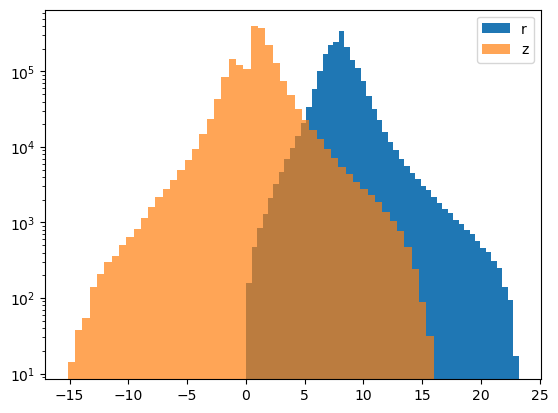

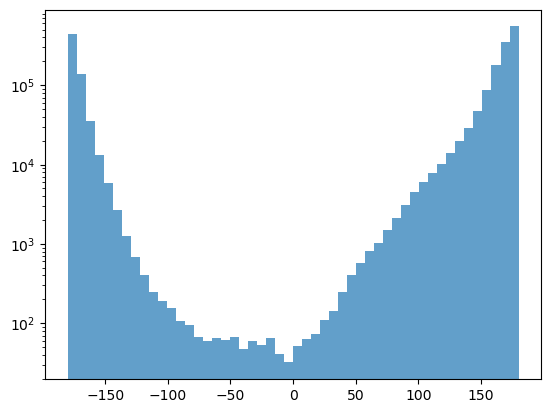

In [19]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 16., dist_min=0.)


plt.hist(r, bins=50, label='r')
#plt.hist(phi, bins=50, alpha=0.7, label='phi')
plt.hist(z, bins=50, alpha=0.7, label='z')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(phi, bins=50, alpha=0.7, label='phi')
plt.yscale('log')
plt.show()

# R, V_phi

# plt.hist2d

In [20]:
import matplotlib

[592, 235]


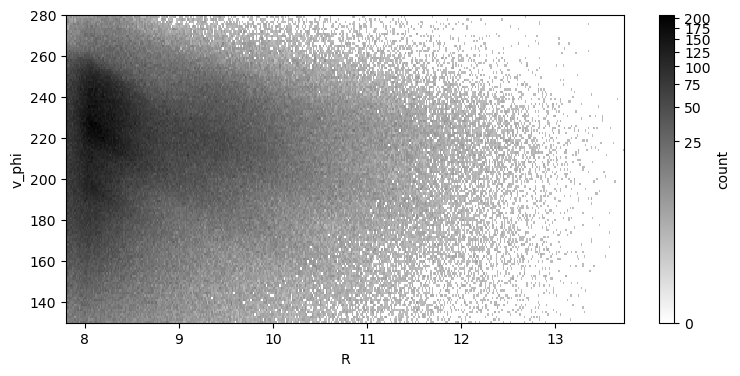

In [21]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0)
ind500 = np.where(((abs(z))<=2.)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>7.8)&(r<20)&
                  #(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))


binning = [2*int((max(r[ind500])-min(r[ind500]))/0.02), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)

fig, ax = plt.subplots(1, figsize=(9,4))
hist = ax.hist2d(r[ind500],  -v_phi[ind500],
           bins=[400, 200],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

#ax.set_xlim(7.7, 20)
ax.set_ylim(130, 280)

ax.set_xlabel('R')
ax.set_ylabel('v_phi')
fig.colorbar(hist[3], label='count',location='right')



# scipy stat binned stat2d


[2178, 235]


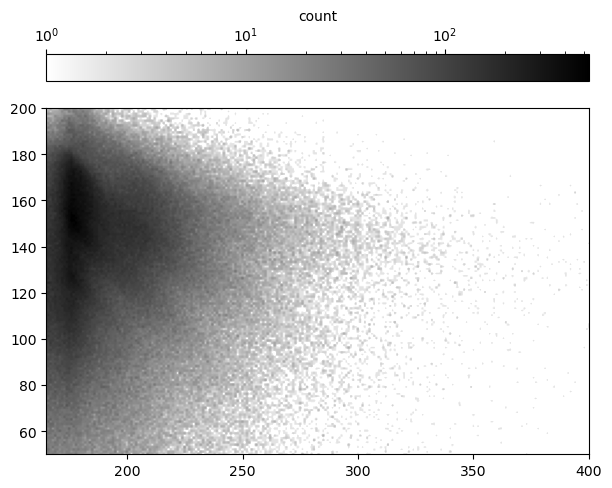

In [22]:
fig, ax = plt.subplots(1, figsize=(7,7))
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0.)
ind500 = np.where(#(z>0.5)&(z<=1.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  #(r>5.5)&(r<10.5)&
                  #(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [500,200]

bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax.imshow(image,
                origin='lower',
                cmap = 'gray_r',
                norm = 'log',
                #vmax = 60,
                #vmin=-0,
                #extent=[-1.5,1.5,-1,1]
               )

#x_label_list = np.array([np.round(min(r[ind500])),np.round(np.median(r[ind500])),np.round(max(r[ind500]))])
#ax.set_xticks([-1.5,-0.5,1.5])
#ax.set_xticklabels(x_label_list)
#ax.set_xlabel('R [kpc]')
ax.set_xlim(165, 400)


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')

ax.set_ylim(50, 200)
fig.colorbar(pcm, ax=ax, location='top', label='count')




# com subtracted with hist2d

[1018, 160]


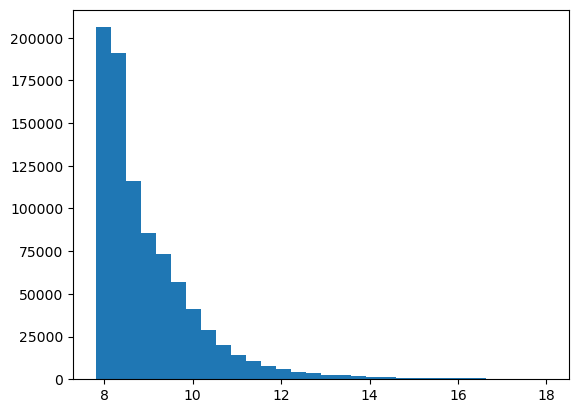

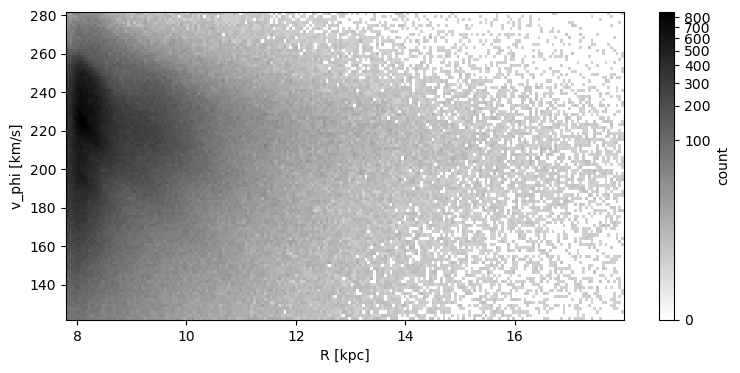

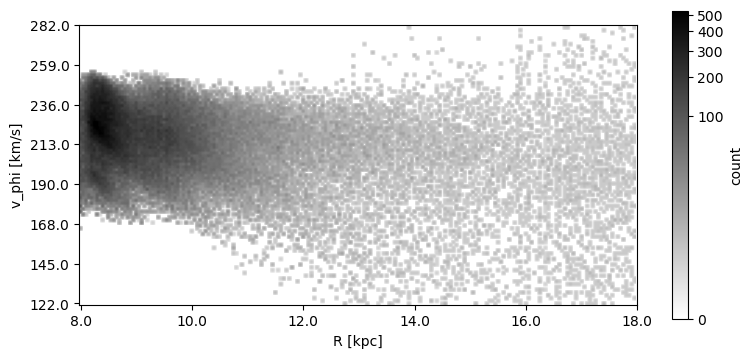

In [23]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0)
ind500 = np.where(#((abs(z))<=2.)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>7.8)&(r<18)&
                  #(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 80))&(v_phi>np.nanpercentile(v_phi, 1)))


plt.hist(r[ind500], bins=30)

binning = [2*int((max(r[ind500])-min(r[ind500]))/0.02), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [200,100]


fig, ax = plt.subplots(1, figsize=(9,4))
hist = ax.hist2d(r[ind500],  -v_phi[ind500],
           bins=[binning[0], binning[1]],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

ax.set_xlabel('R [kpc]')
ax.set_ylabel('v_phi [km/s]')
fig.colorbar(hist[3], label='count',location='right')
#fig.savefig('./plots/r_v_phi_bins_400_200_grayscale.png', dpi=400)

plt.show()

hehe = hist[0].T

image_col_mean = np.copy(hehe)
for i in range(len(hehe[1])): # column length
    image_col_mean[:,i] = hehe[:,i] - np.median(hehe[:,i])
image_col_mean[np.where(image_col_mean <0)] = 0

fig, ax = plt.subplots(1, figsize=(9,4))
pcm = ax.imshow(image_col_mean,
                origin='lower',
                cmap = 'gray_r',
                norm = matplotlib.colors.PowerNorm(gamma=0.25),
                #vmax = 60,
                #vmin=-0,
               )

# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(np.round(xticklabels))
ax.set_yticklabels(np.round(yticklabels))
ax.set_xlabel('R [kpc]')
ax.set_ylabel('v_phi [km/s]')

fig.colorbar(pcm, ax=ax, location='right', label='count')




In [24]:
print(len(hist[1]))

201


## add Z colormap

In [25]:
import matplotlib.colors



In [26]:
x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["firebrick","whitesmoke","steelblue"])

# replicate GAIA ER DR3 distace

[997, 160]


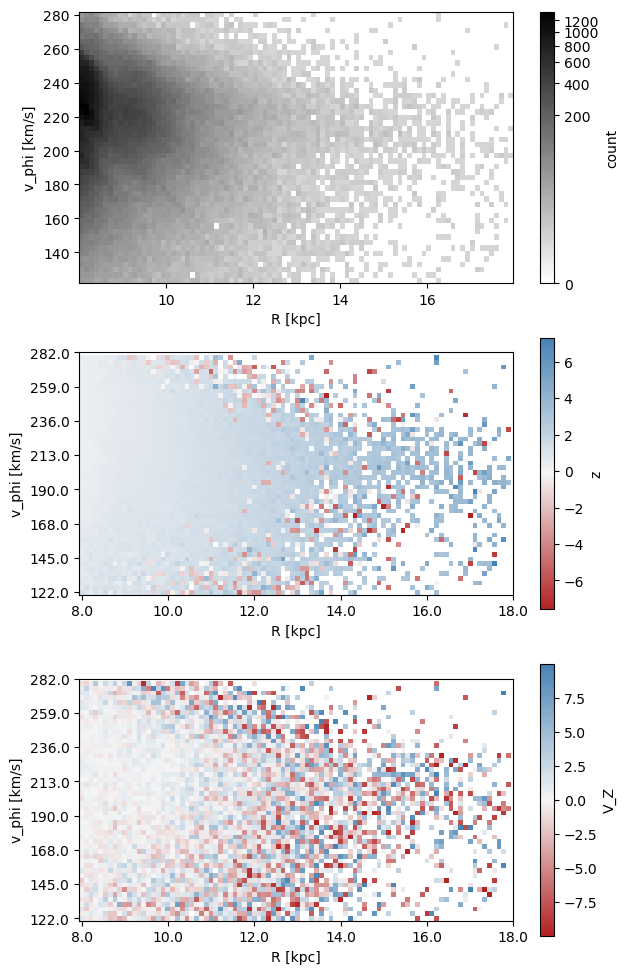

In [27]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0.)
ind500 = np.where(((abs(z))<=8)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>8.)&(r<18.)&
                  (abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [70,50]

binning = [90,50]


fig, ax = plt.subplots(3, 1, figsize=(7,12))
hist = ax[0].hist2d(r[ind500],  -v_phi[ind500],
           bins=[binning[0], binning[1]],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel('v_phi [km/s]')
ax[0].get_xticks()
ax[0].get_xticklabels()
fig.colorbar(hist[3], ax=ax[0],label='count',location='right')
#fig.savefig('./plots/r_v_phi_bins_70_50_grayscale.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[1].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'linear',
                #vmax = 60,
                #vmin=-0,
                #extent=[-1.5,1.5,-1,1]
               )

#med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
#x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[1].set_xticks()
#ax[1].set_xticklabels(ax[0].get_xticklabels())
#ax[1].set_xlabel('R [kpc]')


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].set_xticklabels(np.round(xticklabels))
ax[1].set_yticklabels(np.round(yticklabels))
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[1], location='right', label='z')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)


##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], v_z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[2].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'linear',
                #vmax = 60,
                #vmin=-0,
                #extent=[0,90, 0,50]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[2].set_xticks([-1.5,-0.0,1.5])
#ax[2].set_xticklabels(x_label_list)
#ax[2].set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].set_xticklabels(np.round(xticklabels))
ax[2].set_yticklabels(np.round(yticklabels))
ax[2].set_xlabel('R [kpc]')
ax[2].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[2], location='right', label='V_Z')
#fig.savefig('./plots/r_v_phi_bins_90_50_Z_large.png', dpi=400)



# replicate GAIA ER DR3 color bar scale

[68, 159]


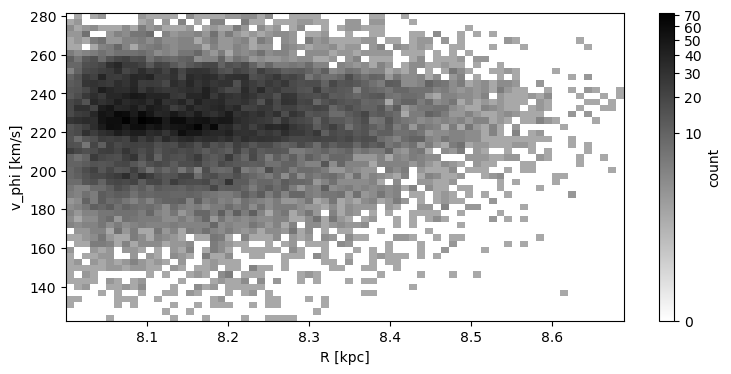

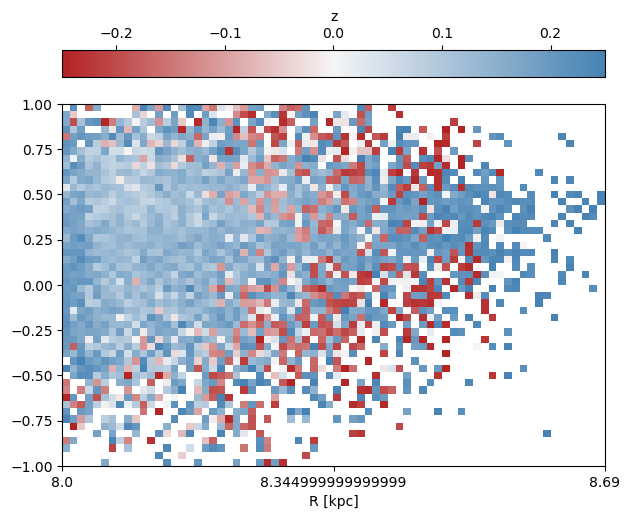

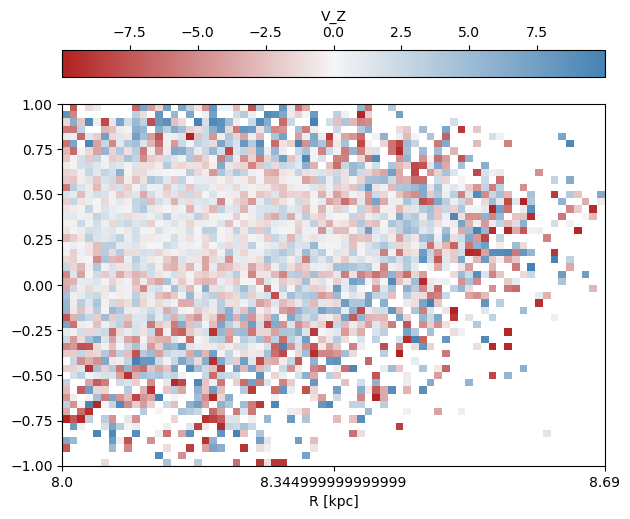

In [28]:

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0.)
ind500 = np.where(((abs(z))<=0.25)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>8.)&(r<18.)&
                  (abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))



binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [70,50]


fig, ax = plt.subplots(1, figsize=(9,4))
hist = ax.hist2d(r[ind500],  -v_phi[ind500],
           bins=[binning[0], binning[1]],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

ax.set_xlabel('R [kpc]')
ax.set_ylabel('v_phi [km/s]')
fig.colorbar(hist[3], label='count',location='right')
#fig.savefig('./plots/r_v_phi_bins_70_50_grayscale.png', dpi=400)

plt.show()

fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax.imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'linear',
                #vmax = 60,
                #vmin=-0,
                extent=[-1.5,1.5,-1,1]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
ax.set_xticks([-1.5,-0.0,1.5])
ax.set_xticklabels(x_label_list)
ax.set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax, location='top', label='z')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################

fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], v_z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax.imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'linear',
                #vmax = 60,
                #vmin=-0,
                extent=[-1.5,1.5,-1,1]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
ax.set_xticks([-1.5,-0.0,1.5])
ax.set_xticklabels(x_label_list)
ax.set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax, location='top', label='V_Z')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)



# one plot

[68, 159]


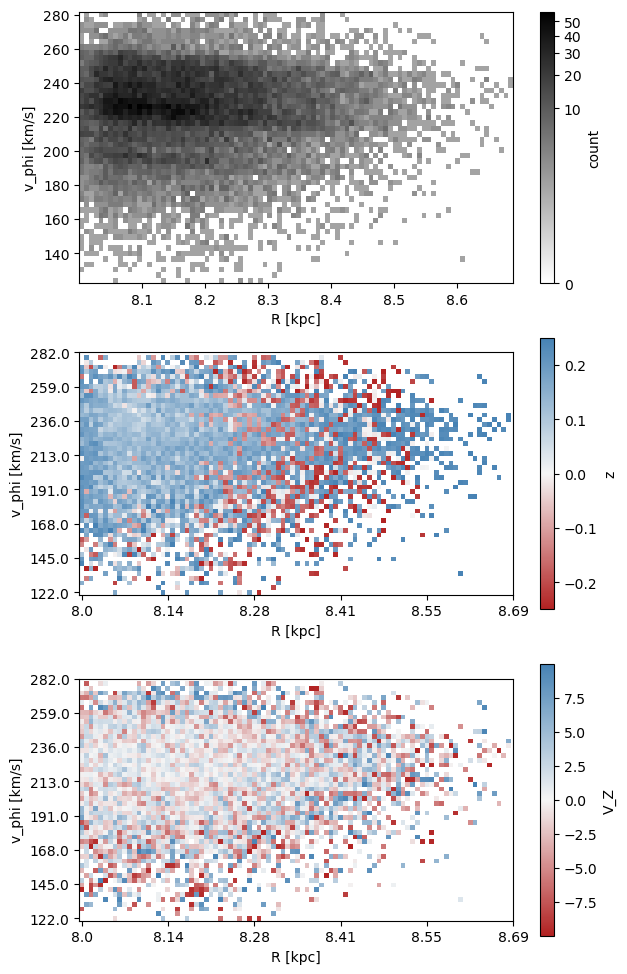

In [29]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0.)
ind500 = np.where(((abs(z))<=0.25)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>8.)&(r<18.)&
                  (abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))


binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [70,50]

binning = [90,50]


fig, ax = plt.subplots(3, 1, figsize=(7,12))
hist = ax[0].hist2d(r[ind500],  -v_phi[ind500],
           bins=[binning[0], binning[1]],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel('v_phi [km/s]')
ax[0].get_xticks()
ax[0].get_xticklabels()
fig.colorbar(hist[3], ax=ax[0],label='count',location='right')
#fig.savefig('./plots/r_v_phi_bins_70_50_grayscale.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[1].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'linear',
                #vmax = 60,
                #vmin=-0,
                #extent=[-1.5,1.5,-1,1]
               )

#med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
#x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[1].set_xticks()
#ax[1].set_xticklabels(ax[0].get_xticklabels())
#ax[1].set_xlabel('R [kpc]')


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].set_xticklabels(np.round(xticklabels, 2))
ax[1].set_yticklabels(np.round(yticklabels))
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[1], location='right', label='z')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)


##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], v_z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[2].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'linear',
                #vmax = 60,
                #vmin=-0,
                #extent=[0,90, 0,50]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[2].set_xticks([-1.5,-0.0,1.5])
#ax[2].set_xticklabels(x_label_list)
#ax[2].set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].set_xticklabels(np.round(xticklabels, 2))
ax[2].set_yticklabels(np.round(yticklabels))
ax[2].set_xlabel('R [kpc]')
ax[2].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[2], location='right', label='V_Z')
#fig.savefig('./plots/r_v_phi_bins_90_50_Z.png', dpi=400)



[992, 160]


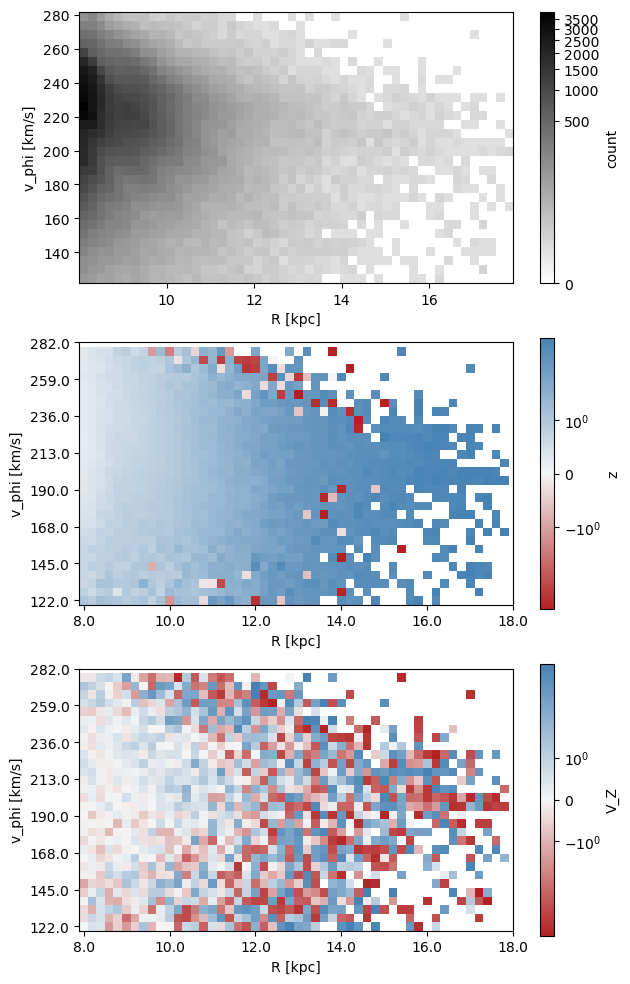

In [30]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0.)
ind500 = np.where(((abs(z))<=4)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>8.)&(r<18.)&
                  (abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [70,50]

binning = [50,30]


fig, ax = plt.subplots(3, 1, figsize=(7,12))
hist = ax[0].hist2d(r[ind500],  -v_phi[ind500],
           bins=[binning[0], binning[1]],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel('v_phi [km/s]')
ax[0].get_xticks()
ax[0].get_xticklabels()
fig.colorbar(hist[3], ax=ax[0],label='count',location='right')
#fig.savefig('./plots/r_v_phi_bins_70_50_grayscale.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[1].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'symlog',
                #vmax = 60,
                #vmin=-0,
                #extent=[-1.5,1.5,-1,1]
               )

#med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
#x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[1].set_xticks()
#ax[1].set_xticklabels(ax[0].get_xticklabels())
#ax[1].set_xlabel('R [kpc]')


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].set_xticklabels(np.round(xticklabels))
ax[1].set_yticklabels(np.round(yticklabels))
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[1], location='right', label='z')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)


##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], v_z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[2].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'symlog',
                #vmax = 60,
                #vmin=-0,
                #extent=[0,90, 0,50]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[2].set_xticks([-1.5,-0.0,1.5])
#ax[2].set_xticklabels(x_label_list)
#ax[2].set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].set_xticklabels(np.round(xticklabels))
ax[2].set_yticklabels(np.round(yticklabels))
ax[2].set_xlabel('R [kpc]')
ax[2].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[2], location='right', label='V_Z')
#fig.savefig('./plots/r_v_phi_bins_50_30_Z_symlog.png', dpi=400)



In [31]:
matplotlib.scale.get_scale_names()

['asinh', 'function', 'functionlog', 'linear', 'log', 'logit', 'symlog']

# look for asymmetries in Z fig 12 in antoja 2021

In [32]:
print(shape(hist[0]))
print(len(hist[1]))
print(len(hist[2]))

(50, 30)
51
31


In [33]:
import scipy.stats as stats

z: 647156
half z: 323578
z>0: 470139 frac 0.73
z<0: 177017 frac 0.27


Text(0.5, 1.0, 'z<9 kpc')

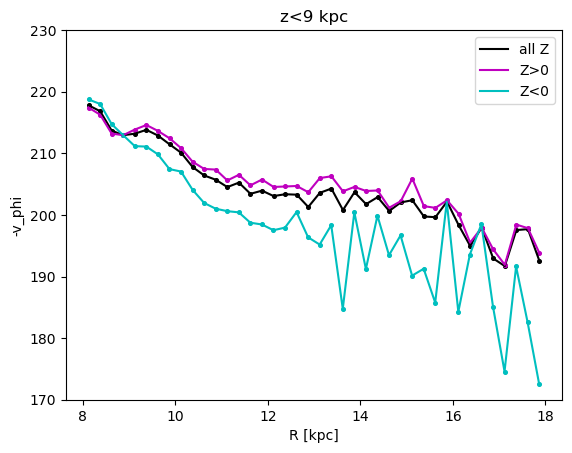

In [54]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0)
ind500 = np.where(((abs(z))<=9)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>8.)&(r<18.)&
                  #(abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))

print('z:',len(z[ind500]))
print('half z:',len(z[ind500])//2)
print('z>0:',len(np.where(z[ind500]>0)[0]), 'frac', np.round(len(np.where(z[ind500]>0)[0])/len(z[ind500]), 2))
print('z<0:',len(np.where(z[ind500]<0)[0]), 'frac', np.round(len(np.where(z[ind500]<0)[0])/len(z[ind500]), 2))

r_all = r[ind500]
v_phi_all = -v_phi[ind500]
z_all = z[ind500]

r_z_gr_0 = r_all[np.where(z_all>0)]
v_phi_z_gr_0 = v_phi_all[np.where(z_all>0)]

r_z_ls_0 = r_all[np.where(z_all<0)]
v_phi_z_ls_0 = v_phi_all[np.where(z_all<0)]

binns=40

##################################################################################
##################################################################################
##################################################################################

bin_means, bin_edges, binnumber = stats.binned_statistic(r_all, v_phi_all,
        statistic='median', bins=binns)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,label='binned statistic of data')
plt.plot(bin_centers, bin_means, 'k', label='all Z')
plt.scatter(bin_centers, bin_means, c='k', s=7)


##################################################################################
##################################################################################
##################################################################################

bin_means, bin_edges, binnumber = stats.binned_statistic(r_z_gr_0, v_phi_z_gr_0,
        statistic='median', bins=binns)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,label='binned statistic of data')
plt.plot(bin_centers, bin_means, 'm', label='Z>0')
plt.scatter(bin_centers, bin_means, c='m', s=7)

##################################################################################
##################################################################################
##################################################################################

bin_means, bin_edges, binnumber = stats.binned_statistic(r_z_ls_0, v_phi_z_ls_0,
        statistic='median', bins=binns)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,label='binned statistic of data')
plt.plot(bin_centers, bin_means, 'c', label='Z<0')
plt.scatter(bin_centers, bin_means, c='c', s=7)


plt.ylim(170, 230)
plt.ylabel('-v_phi')
plt.xlabel('R [kpc]')
plt.legend(fontsize=10)
plt.title('z<9 kpc')




# map to V_r

[997, 160]
-2.681794806021883


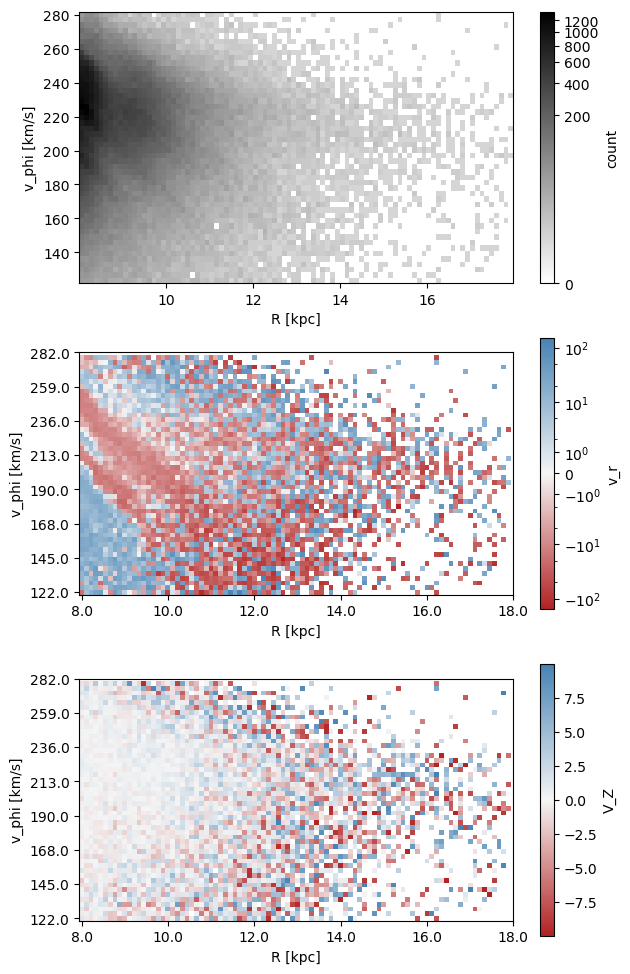

In [55]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0.)
ind500 = np.where(((abs(z))<=8)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>8.)&(r<18.)&
                  (abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [70,50]

binning = [90,50]


fig, ax = plt.subplots(3, 1, figsize=(7,12))
hist = ax[0].hist2d(r[ind500],  -v_phi[ind500],
           bins=[binning[0], binning[1]],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel('v_phi [km/s]')
ax[0].get_xticks()
ax[0].get_xticklabels()
fig.colorbar(hist[3], ax=ax[0],label='count',location='right')
#fig.savefig('./plots/r_v_phi_bins_70_50_grayscale.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], v_r[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

print(np.median(v_r[ind500]))

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[1].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'asinh',
                #vmax = 60,
                #vmin=-0,
                #extent=[-1.5,1.5,-1,1]
               )

#med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
#x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[1].set_xticks()
#ax[1].set_xticklabels(ax[0].get_xticklabels())
#ax[1].set_xlabel('R [kpc]')


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].set_xticklabels(np.round(xticklabels))
ax[1].set_yticklabels(np.round(yticklabels))
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[1], location='right', label='v_r')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)


##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], v_z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax[2].imshow(image,
                origin='lower',
                cmap = cmap,
                norm = 'linear',
                #vmax = 60,
                #vmin=-0,
                #extent=[0,90, 0,50]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[2].set_xticks([-1.5,-0.0,1.5])
#ax[2].set_xticklabels(x_label_list)
#ax[2].set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].set_xticklabels(np.round(xticklabels))
ax[2].set_yticklabels(np.round(yticklabels))
ax[2].set_xlabel('R [kpc]')
ax[2].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\ph
fig.colorbar(pcm, ax=ax[2], location='right', label='V_Z')
#fig.savefig('./plots/r_v_phi_bins_90_50_V_R_stripes.png', dpi=400)


# metallicities

0.33589146228042105 0.1941539878827848
-0.40215273484236613 -0.769943044984787


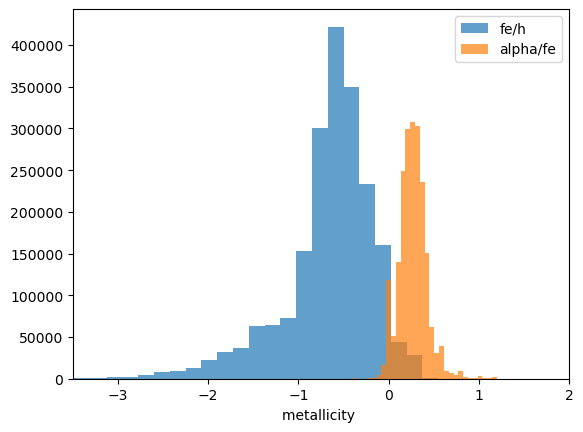

In [56]:
print(np.nanpercentile(alphafe, 70.), np.nanpercentile(alphafe, 30.))
print(np.nanpercentile(feh, 70.), np.nanpercentile(feh, 30.))

plt.hist(feh, bins=30, alpha=0.7,label='fe/h')
plt.hist(alphafe, bins=30, alpha=0.7, label='alpha/fe')
plt.xlabel('metallicity ')
plt.xlim(-3.5, 2)
plt.legend()
plt.show()


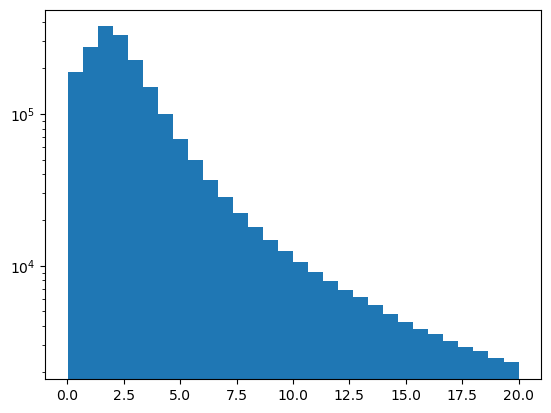

In [57]:
plt.hist(dist[np.where(dist<20)], bins=30)
plt.yscale('log')

[1197, 160]
-0.35806618758224434


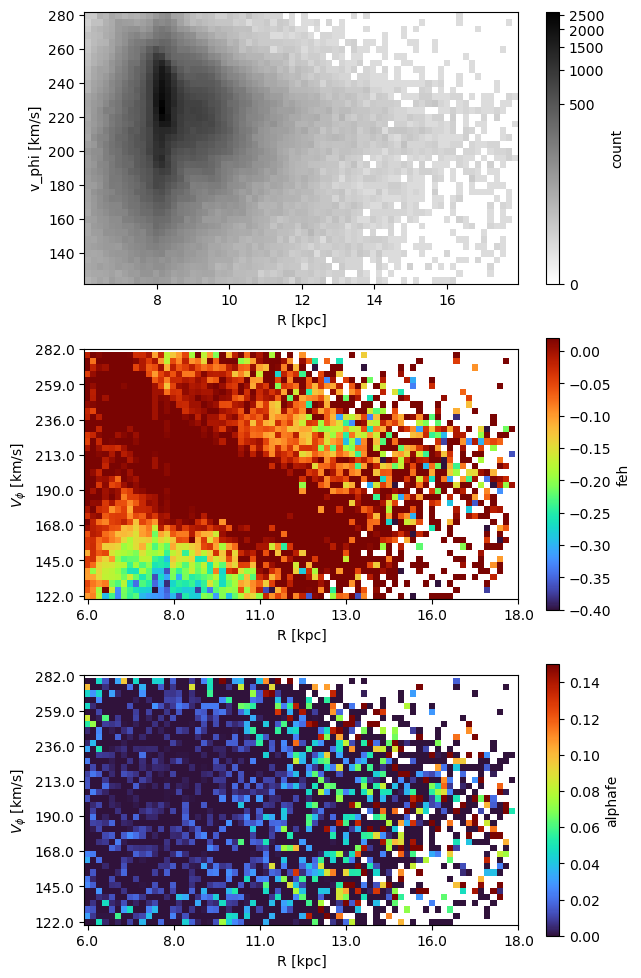

In [58]:
dist_max = 15
dist_min = 0
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, 
                                                 dist_max = dist_max, dist_min=dist_min)
dist_index = np.where((dist<=dist_max) & (dist>dist_min))
feh_1 = feh[dist_index]
alphafe_1 = alphafe[dist_index]

ind500 = np.where(((abs(z))<=8)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>6.)&(r<18.)&
                  (abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [70,50]

binning = [90,50]
binning = [70,40]


fig, ax = plt.subplots(3, 1, figsize=(7,4*3))
hist = ax[0].hist2d(r[ind500],  -v_phi[ind500],
           bins=[binning[0], binning[1]],
           cmap='gray_r',
           norm=matplotlib.colors.PowerNorm(gamma=0.25))

ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel('v_phi [km/s]')
ax[0].get_xticks()
ax[0].get_xticklabels()
fig.colorbar(hist[3], ax=ax[0],label='count',location='right')
#fig.savefig('./plots/r_v_phi_bins_70_50_grayscale.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], feh_1[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

print(np.median(feh_1[ind500]))

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.nanmedian(image[:,i])


pcm = ax[1].imshow(image_col_mean,
                origin='lower',
                cmap = 'turbo',
                norm = 'linear',
                vmax = 0.02,
                vmin=-0.4,
                #extent=[-1.5,1.5,-1,1]
               )

#med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
#x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[1].set_xticks()
#ax[1].set_xticklabels(ax[0].get_xticklabels())
#ax[1].set_xlabel('R [kpc]')


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].set_xticklabels(np.round(xticklabels))
ax[1].set_yticklabels(np.round(yticklabels))
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel(r'$V_\phi$ [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[1], location='right', label='feh')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################

#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], alphafe_1[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.nanmedian(image[:,i])

pcm = ax[2].imshow(image_col_mean,
                origin='lower',
                cmap = 'turbo',
                norm = 'linear',
                vmax = 0.15,
                vmin=0.00,
                #extent=[0,90, 0,50]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[2].set_xticks([-1.5,-0.0,1.5])
#ax[2].set_xticklabels(x_label_list)
#ax[2].set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].set_xticklabels(np.round(xticklabels))
ax[2].set_yticklabels(np.round(yticklabels))
ax[2].set_xlabel('R [kpc]')
ax[2].set_ylabel(r'$V_\phi$ [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\ph
fig.colorbar(pcm, ax=ax[2], location='right', label='alphafe')
fig.savefig('./plots/r_v_phi_bins_70_50_metallicity_fe_and_alpha.png', dpi=400)




-0.5819514533969299
(array([     0,      5,      9, ..., 376133, 376336, 376393]),)
[8.03745761 7.95535429 8.04741242 ... 9.20308593 8.87331489 8.51458786]
[     0      5      9 ... 376133 376336 376393]
[8.03745761 7.60609865 7.92705639 ... 8.97107592 9.01441182 9.22258478]
-0.38469255992039175


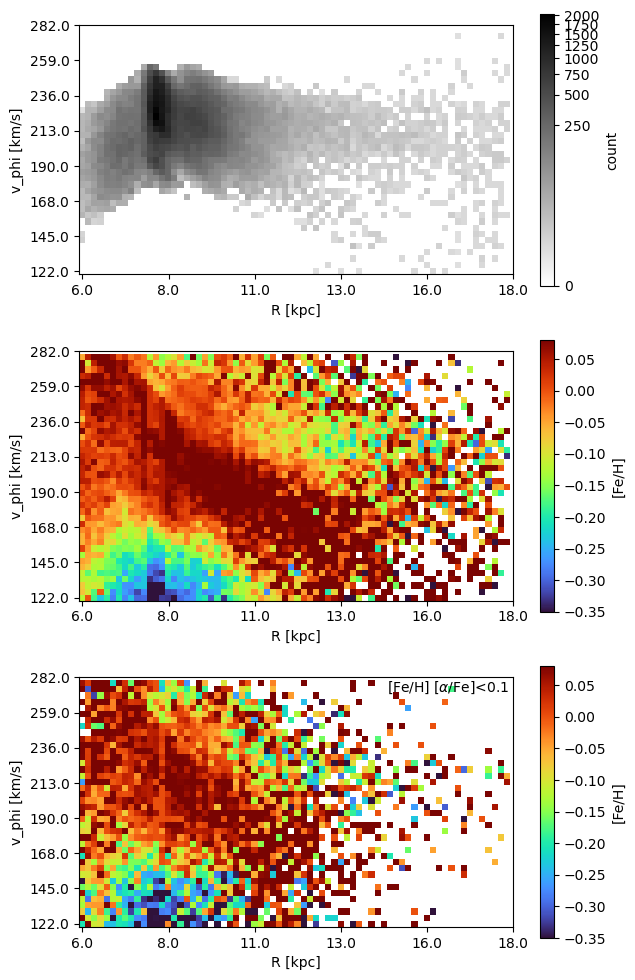

In [66]:
dist_max = 15
dist_min = 0
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0.)

dist_index = np.where((dist<=dist_max) & (dist>dist_min))
feh_1 = feh[dist_index]
alphafe_1 = alphafe[dist_index]

ind500 = np.where(((abs(z))<=8)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>6.)&(r<18.)&
                  (abs(v_z)<10)&
                  (v_phi<np.nanpercentile(v_phi, 80.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
binning = [70,40]

fig, ax = plt.subplots(3, 1, figsize=(7,4*3))

# density plot in R , V_phi
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.nanmedian(image[:,i])
image_col_mean[np.where(image_col_mean <0)] = 0

pcm = ax[0].imshow(image_col_mean,
                origin='lower',
                cmap = 'gray_r',
                norm = matplotlib.colors.PowerNorm(gamma=0.25),
                #vmax = 60,
                #vmin=0,
                #extent=[0,90, 0,50]
               )

med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[2].set_xticks([-1.5,-0.0,1.5])
#ax[2].set_xticklabels(x_label_list)
#ax[2].set_xlabel('R [kpc]')
#ax.set_xlim(165, 400)


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[0].set_xticks(xticks)
ax[0].set_yticks(yticks)
ax[0].set_xticklabels(np.round(xticklabels))
ax[0].set_yticklabels(np.round(yticklabels))
ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\ph
fig.colorbar(pcm, ax=ax[0], location='right', label='count')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################


#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], feh_1[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

print(np.median(feh[ind500]))

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.nanmedian(image[:,i])
    

pcm = ax[1].imshow(image_col_mean,
                origin='lower',
                cmap = 'turbo',
                norm = 'linear',
                vmax = 0.08,
                vmin=-0.35,
                #extent=[-1.5,1.5,-1,1]
               )

#med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
#x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[1].set_xticks()
#ax[1].set_xticklabels(ax[0].get_xticklabels())
#ax[1].set_xlabel('R [kpc]')


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].set_xticklabels(np.round(xticklabels))
ax[1].set_yticklabels(np.round(yticklabels))
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[1], location='right', label='[Fe/H]')
#fig.savefig('./plots/r_v_phi_bins_70_50_Z.png', dpi=400)

##################################################################################################################
##################################################################################################################
#################################################################################################################
r_ind500 = r[ind500]
v_phi_ind500 = v_phi[ind500]
feh_ind500 = feh_1[ind500]
feh_ind500 = feh_1[ind500]
alphafe_ind500 = alphafe_1[ind500]

index_alphafe = (np.where(alphafe_ind500 < 0.1))
print(index_alphafe)
print(r_ind500)
print(index_alphafe[0])
print(r_ind500[index_alphafe])



#fig, ax = plt.subplots(1, figsize=(7,7))
bin_r_vphi = scipy.stats.binned_statistic_2d(r_ind500[index_alphafe], -v_phi_ind500[index_alphafe],
                                             feh_ind500[index_alphafe], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

print(np.median(feh_ind500[index_alphafe]))

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.nanmedian(image[:,i])

pcm = ax[2].imshow(image_col_mean,
                origin='lower',
                cmap = 'turbo',
                norm = 'linear',
                vmax = 0.08,
                vmin=-0.35,
                #extent=[-1.5,1.5,-1,1]
               )

#med_r = (np.round(min(r[ind500]),2)+np.round(max(r[ind500]),2))/2
#x_label_list = np.array([np.round(min(r[ind500]),2),med_r,np.round(max(r[ind500]),2)])
#ax[1].set_xticks()
#ax[1].set_xticklabels(ax[0].get_xticklabels())
#ax[1].set_xlabel('R [kpc]')


# Where we want the ticks, in pixel locations
xticks = np.linspace(0, binning[0], 6)
yticks = np.linspace(0, binning[1], 8)

x_px = np.arange(0, len(hist[1]), 1)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
m1,b1 = np.polyfit(x_px, hist[1], 1)
xticklabels = m1*xticks + b1

y_px = np.arange(0, len(hist[2]), 1)
m2,b2 = np.polyfit(y_px, hist[2], 1)
yticklabels = m2*yticks + b2

ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].set_xticklabels(np.round(xticklabels))
ax[2].set_yticklabels(np.round(yticklabels))
ax[2].set_xlabel('R [kpc]')
ax[2].set_ylabel('v_phi [km/s]')


#y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(y_label_list)
#ax.set_ylabel('$v_\phi$ [km/s]')
#ax.set_ylim(50, 200)

fig.colorbar(pcm, ax=ax[2], location='right', label='[Fe/H]')
plt.text(.99, .99, r'[Fe/H] [$\alpha$/Fe]<0.1', ha='right', va='top', transform=ax[2].transAxes)
#fig.savefig('./plots/r_v_phi_bins_70_40_metallicity_new_scale.png', dpi=400)


